In [1]:
import os
import numpy as np
import random
import concurrent.futures
import shutil
from tensorflow.keras import layers, models, backend as K

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, Input
import tensorflow as tf
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import threading
import cv2

import time

In [2]:
class Config:
    INPUT_SIZE = (224, 224)
    NUM_EPOCHS = 20
    DATASET_PATH = "/kaggle/input/pins-face-recognition/105_classes_pins_dataset"
    TRAIN_DIR = os.path.join("/kaggle/working/", "train")
    VAL_DIR = os.path.join("/kaggle/working/", "val")
    TEST_DIR = os.path.join("/kaggle/working/", "test")
    MIN_IMGS = 200
    BATCH_SIZE = 64

config = Config()

In [3]:
for dir_path in [config.TRAIN_DIR, config.VAL_DIR, config.TEST_DIR]:
    os.makedirs(dir_path, exist_ok=True)

# Select folders with ≥100 images
all_folders = [f for f in os.listdir(config.DATASET_PATH) if os.path.isdir(os.path.join(config.DATASET_PATH, f))]
valid_folders = [folder for folder in all_folders if len(os.listdir(os.path.join(config.DATASET_PATH, folder))) >= config.MIN_IMGS]

# Select 20 random folders (classes)
selected_folders = random.sample(valid_folders, min(20, len(valid_folders)))
print(f"✅ Selected {len(selected_folders)} classes")
# Copy images into train/val/test directories
for folder in selected_folders:
    folder_path = os.path.join(config.DATASET_PATH, folder)
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    # Split into train (80%), val (10%), and test (10%)
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(test_imgs, test_size=0.5, random_state=42)

    train_folder = os.path.join(config.TRAIN_DIR, folder)
    os.makedirs(train_folder, exist_ok=True)
    for img in train_imgs:
        shutil.copy(os.path.join(folder_path, img), os.path.join(train_folder, img))

    val_folder = os.path.join(config.VAL_DIR, folder)
    os.makedirs(val_folder, exist_ok=True)
    for img in val_imgs:
        shutil.copy(os.path.join(folder_path, img), os.path.join(val_folder, img))

    test_folder = os.path.join(config.TEST_DIR, folder)
    os.makedirs(test_folder, exist_ok=True)
    for img in test_imgs:
        shutil.copy(os.path.join(folder_path, img), os.path.join(test_folder, img))

print("Dataset split into train, validation, and test sets")

✅ Selected 18 classes
Dataset split into train, validation, and test sets


In [4]:
for dir_path, set_name in zip([config.TRAIN_DIR, config.VAL_DIR, config.TEST_DIR], ['Train', 'Validation', 'Test']):
    total_images = sum([len(files) for _, _, files in os.walk(dir_path)])
    print(f"{set_name} images: {total_images}")

Train images: 3085
Validation images: 385
Test images: 397


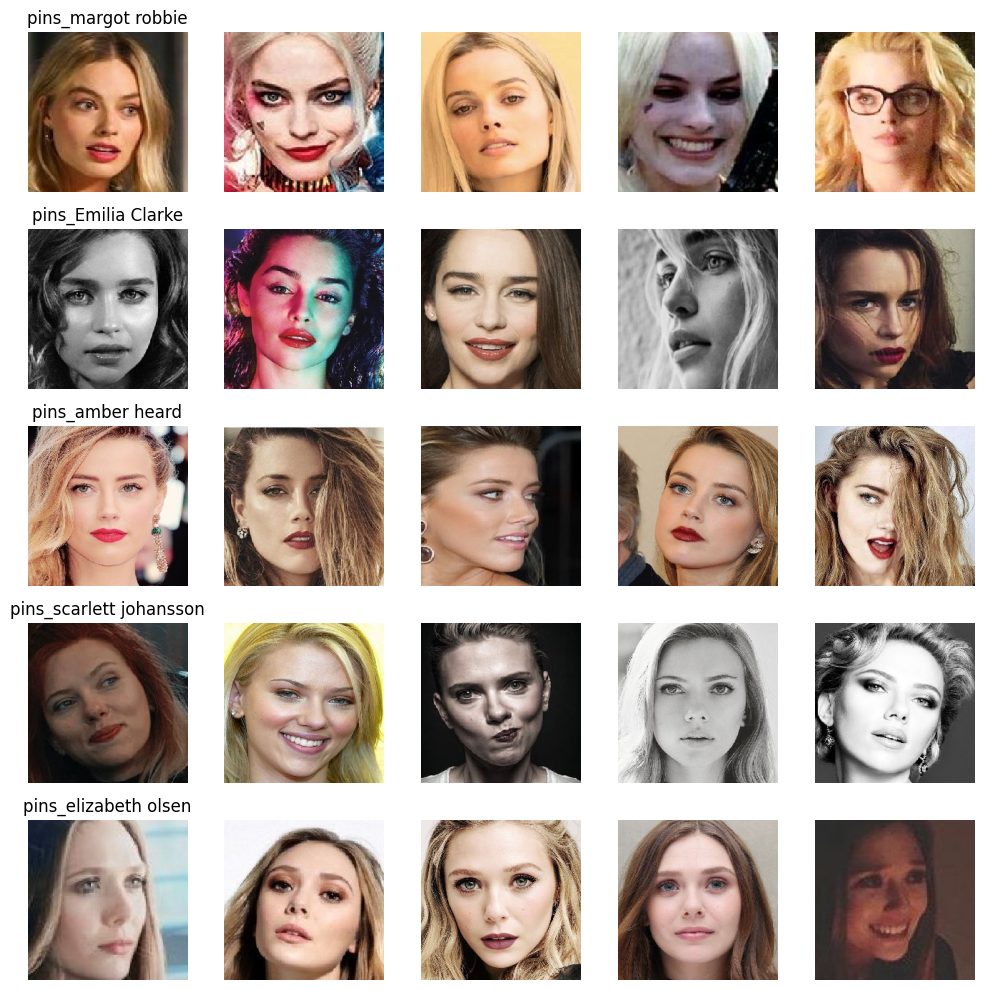

In [5]:
class_names = os.listdir(config.TRAIN_DIR)  # Get all class names

selected_classes = random.sample(class_names, 5)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # 5x5 grid
for i, class_name in enumerate(selected_classes):
    class_path = os.path.join(config.TRAIN_DIR, class_name)
    image_files = os.listdir(class_path)
    
    # Select 5 random images from this class
    selected_images = random.sample(image_files, 5)
    
    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path, target_size=(224, 224)) 
        img = img_to_array(img) / 255.0  # Normalize
        
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(class_name) 

plt.tight_layout()
plt.show()


<ipython-input-6-06a5c6213363>:35: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


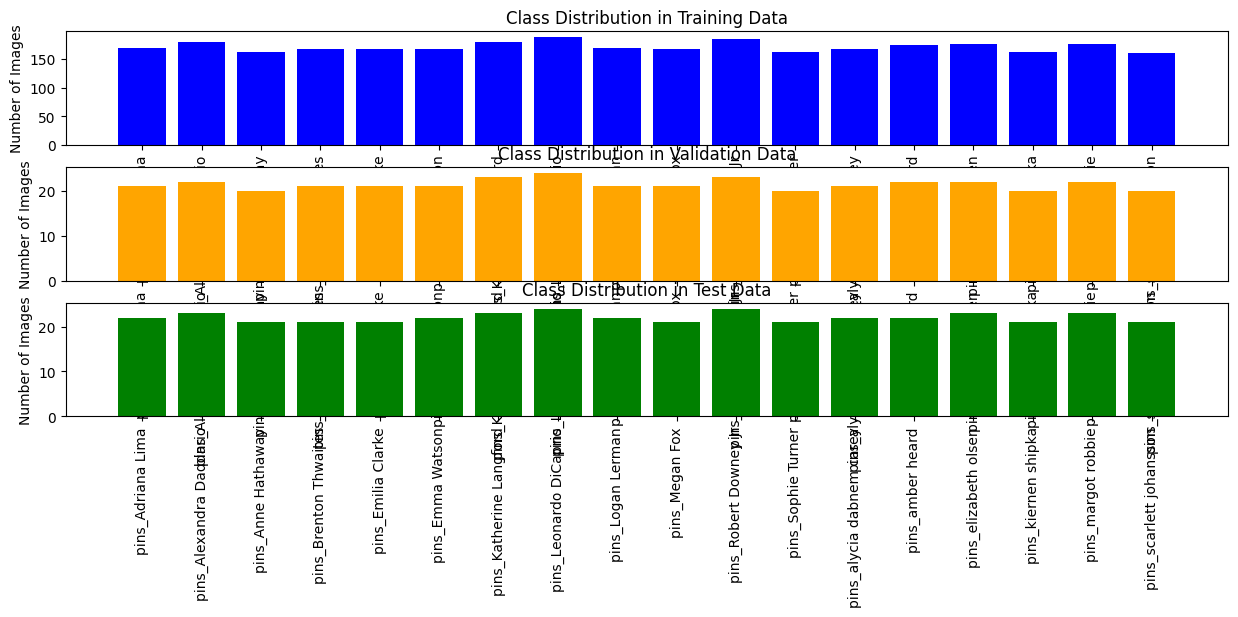

In [6]:

# Function to count images per class in a directory
def count_images(directory):
    class_counts = {}
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            class_counts[class_folder] = len([f for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
    return class_counts

train_counts = count_images(config.TRAIN_DIR)
val_counts = count_images(config.VAL_DIR)
test_counts = count_images(config.TEST_DIR)

train_counts = dict(sorted(train_counts.items()))
val_counts = dict(sorted(val_counts.items()))
test_counts = dict(sorted(test_counts.items()))

fig, ax = plt.subplots(3, 1, figsize=(15, 5))

ax[0].bar(train_counts.keys(), train_counts.values(), color='blue')
ax[0].set_title("Class Distribution in Training Data")
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_ylabel("Number of Images")

ax[1].bar(val_counts.keys(), val_counts.values(), color='orange')
ax[1].set_title("Class Distribution in Validation Data")
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_ylabel("Number of Images")

ax[2].bar(test_counts.keys(), test_counts.values(), color='green')
ax[2].set_title("Class Distribution in Test Data")
ax[2].tick_params(axis='x', rotation=90)
ax[2].set_ylabel("Number of Images")

plt.tight_layout()
plt.show()


In [7]:
def create_triplets(directory, folders, num_triplets=5000):
    triplets = []
    person_images = {folder: os.listdir(os.path.join(directory, folder)) for folder in folders}

    def generate_triplets():
        """Generate triplets in a thread-safe way."""
        nonlocal triplets
        local_triplets = []
        
        while len(local_triplets) < num_triplets // 4:  # Split work among 4 threads
            person = random.choice(folders)
            images = person_images[person]

            if len(images) < 2:
                continue

            anchor, positive = random.sample(images, 2)
            negative_person = random.choice([p for p in folders if p != person])
            negative = random.choice(person_images[negative_person])

            local_triplets.append((
                os.path.join(directory, person, anchor),
                os.path.join(directory, person, positive),
                os.path.join(directory, negative_person, negative)
            ))

        # Extend the shared list in a thread-safe way
        triplets.extend(local_triplets)

    # Use multiple threads for speed
    threads = []
    for _ in range(4):  # Use 4 threads
        thread = threading.Thread(target=generate_triplets)
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    # Ensure we reach exactly num_triplets
    random.shuffle(triplets)
    return triplets[:num_triplets]

In [8]:
train_triplet = create_triplets(config.TRAIN_DIR, selected_folders, num_triplets=15000)
val_triplet = create_triplets(config.VAL_DIR, selected_folders, num_triplets=3000)
test_triplet  = create_triplets(config.TEST_DIR, selected_folders, num_triplets=3000)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 15000
Number of testing triplets : 3000

Examples of triplets:
('/kaggle/working/train/pins_kiernen shipka/kiernen shipka233_2386.jpg', '/kaggle/working/train/pins_kiernen shipka/kiernen shipka211_2368.jpg', '/kaggle/working/train/pins_Logan Lerman/Logan Lerman125_2311.jpg')
('/kaggle/working/train/pins_Leonardo DiCaprio/Leonardo DiCaprio17_2528.jpg', '/kaggle/working/train/pins_Leonardo DiCaprio/Leonardo DiCaprio113_2485.jpg', '/kaggle/working/train/pins_elizabeth olsen/elizabeth olsen145_1154.jpg')
('/kaggle/working/train/pins_Emilia Clarke/Emilia Clarke175_933.jpg', '/kaggle/working/train/pins_Emilia Clarke/Emilia Clarke104_868.jpg', '/kaggle/working/train/pins_alycia dabnem carey/alycia dabnem carey94_205.jpg')
('/kaggle/working/train/pins_Megan Fox/Megan Fox6_3538.jpg', '/kaggle/working/train/pins_Megan Fox/Megan Fox131_3397.jpg', '/kaggle/working/train/pins_Sophie Turner/Sophie Turner95_1017.jpg')
('/kaggle/working/train/pins_Emma Watson/Emma Watson24

In [9]:
def read_image(image_path):
    img = load_img(image_path, target_size=config.INPUT_SIZE)
    img = img_to_array(img)
    return img

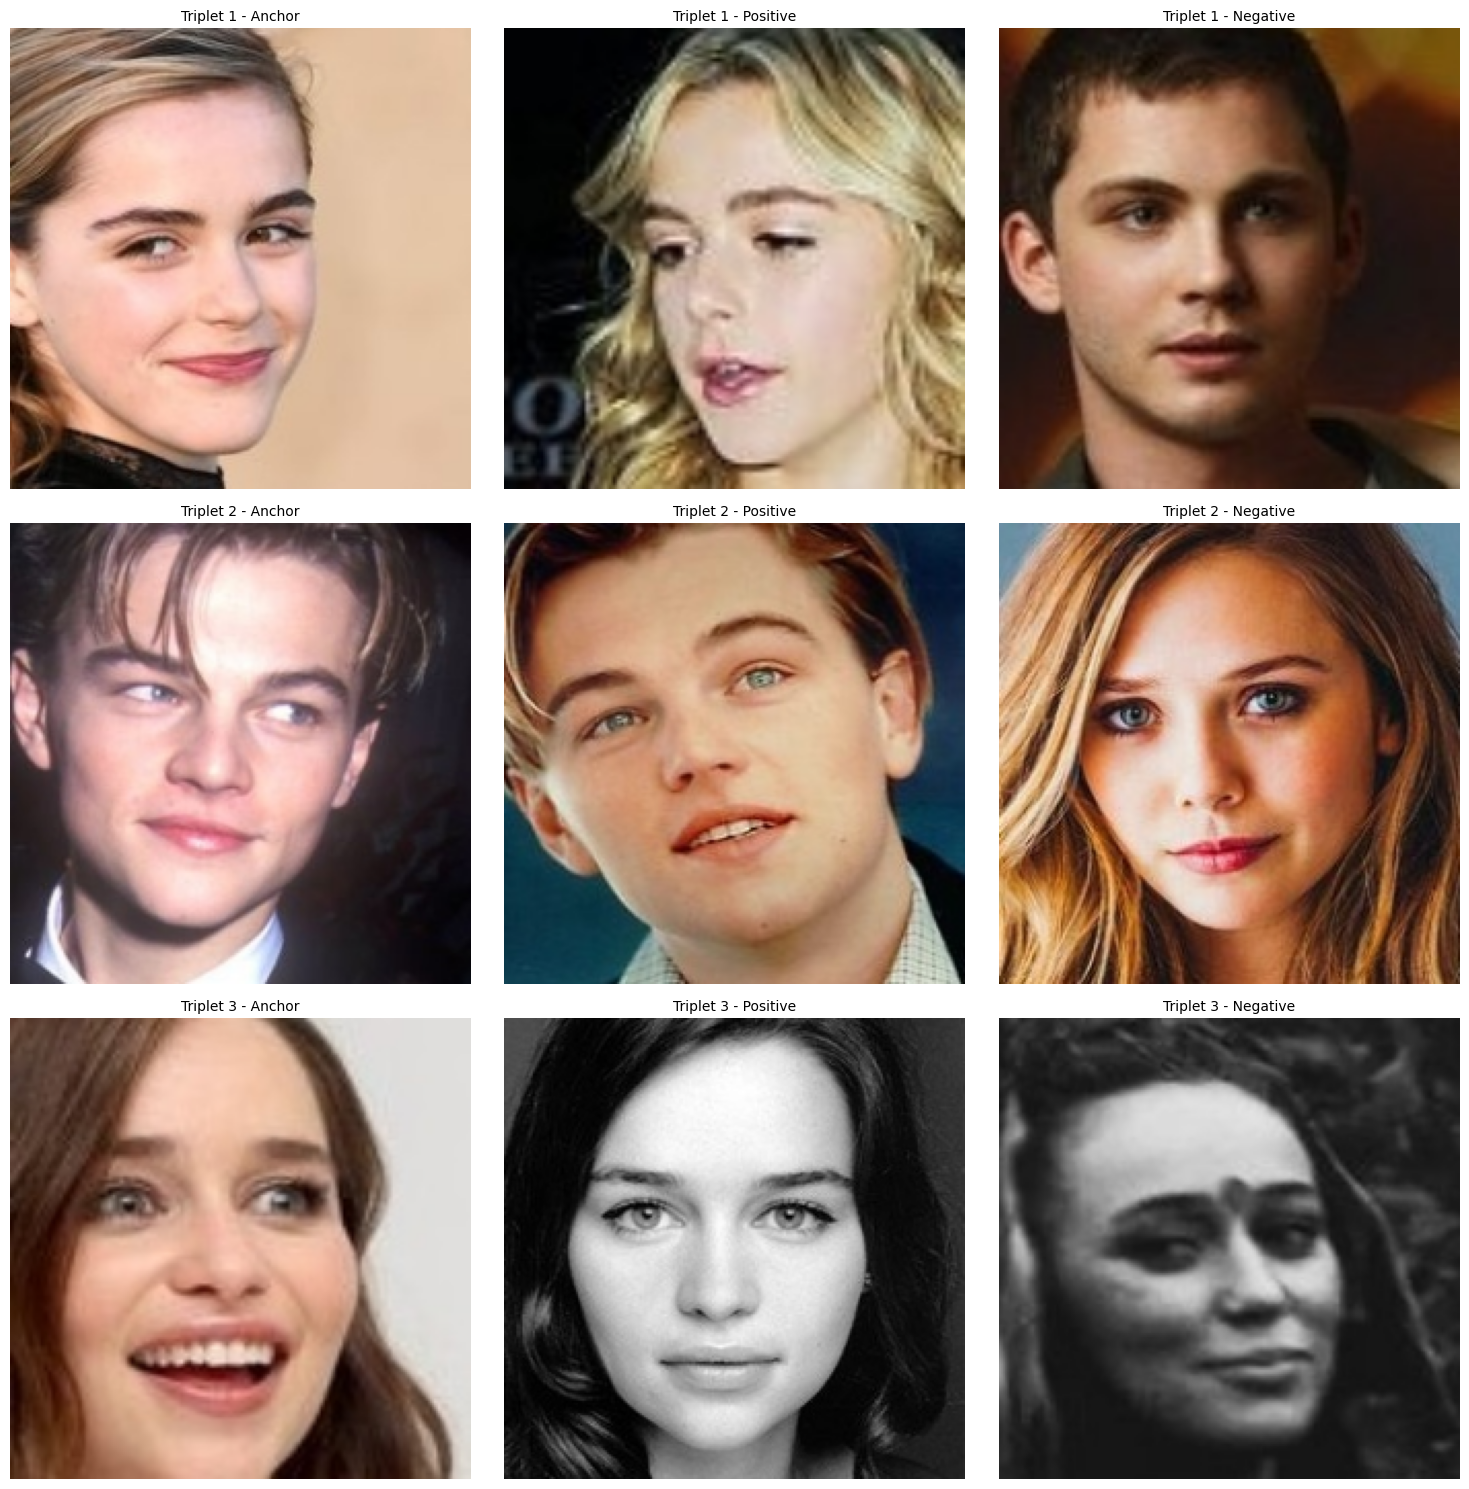

In [10]:
def plot_triplet_samples(triplet_list, num_samples=3):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        if i >= len(triplet_list):
            break
            
        anchor_path, positive_path, negative_path = triplet_list[i]
        
        # Load and process images
        def process_image(path):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            return img
        
        try:
            anchor = process_image(anchor_path)
            positive = process_image(positive_path)
            negative = process_image(negative_path)
        except Exception as e:
            print(f"Error loading triplet {i}: {e}")
            continue

        # Plot anchor
        axes[i,0].imshow(anchor)
        axes[i,0].axis('off')
        axes[i,0].set_title(f"Triplet {i+1} - Anchor", fontsize=10)
        
        # Plot positive
        axes[i,1].imshow(positive)
        axes[i,1].axis('off') 
        axes[i,1].set_title(f"Triplet {i+1} - Positive", fontsize=10)
        
        # Plot negative
        axes[i,2].imshow(negative)
        axes[i,2].axis('off')
        axes[i,2].set_title(f"Triplet {i+1} - Negative", fontsize=10)

    plt.tight_layout()
    plt.show()

# Usage
plot_triplet_samples(train_triplet, num_samples=3)

In [11]:
class L2NormalizeLayer(layers.Layer):
    def __init__(self, axis=-1):
        super(L2NormalizeLayer, self).__init__()
        self.axis = axis

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)
        
    def get_config(self):
        return {'axis': self.axis}

def build_embedding_model(training=True):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers[-20:]:
        layer.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    inputs = layers.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=training)  
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Add dropout to reduce overfitting
    outputs = L2NormalizeLayer()(x)
    
    return models.Model(inputs, outputs)

        
def build_siamese_model(embedding_model):
    anchor_input = layers.Input(shape=(224, 224, 3), name='anchor_input')
    positive_input = layers.Input(shape=(224, 224, 3), name='positive_input')
    negative_input = layers.Input(shape=(224, 224, 3), name='negative_input')

    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    concatenated = layers.concatenate([anchor_embedding, positive_embedding, negative_embedding])
    
    siamese_network = models.Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=concatenated  # Single output
    )
    return siamese_network

In [12]:
def triplet_loss(y_true, y_pred, margin=1.0):
    anchor, positive, negative = tf.split(y_pred, 3, axis=1)
    
    positive_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    negative_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    
    loss_1 = tf.add(tf.subtract(positive_dist, negative_dist), margin)
    
    # Apply the max(., 0) to ensure non-negative loss
    loss = tf.reduce_mean(tf.maximum(loss_1, 0.0))
    
    return loss

def siamese_accuracy(y_true, y_pred):
    anchor, positive, negative = tf.split(y_pred, 3, axis=1)
    pos_sim = tf.reduce_sum(anchor * positive, axis=-1)
    neg_sim = tf.reduce_sum(anchor * negative, axis=-1)
    return tf.reduce_mean(tf.cast(pos_sim > neg_sim, tf.float32))

In [13]:

def create_optimized_dataset(triplet_list, batch_size=64, augment=False):
    """Create a dataset that returns (anchor, positive, negative) as separate inputs."""
    
    # 1. Parallel loading and preprocessing
    def load_and_preprocess(anchor_path, positive_path, negative_path):
        def process_image(path):
            img = tf.io.read_file(path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, [224, 224])
            img = preprocess_input(img)  # MobileNetV2 preprocessing
            return img
            
        return (
            process_image(anchor_path),
            process_image(positive_path),
            process_image(negative_path)
        )

    # 2. Create dataset from tensor slices
    anchor_paths = [a for a, p, n in triplet_list]
    positive_paths = [p for a, p, n in triplet_list]
    negative_paths = [n for a, p, n in triplet_list]
    
    # Create dataset with explicit input structure
    dataset = tf.data.Dataset.from_tensor_slices(
        (anchor_paths, positive_paths, negative_paths)
    )
    
    # 3. Map to preprocessed images
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    # 4. Augmentation (if enabled)
    if augment:
        def augment_images(a, p, n):
            seed = tf.random.uniform([2], maxval=int(1e9), dtype=tf.int32)
            a = tf.image.stateless_random_flip_left_right(a, seed)
            p = tf.image.stateless_random_flip_left_right(p, seed)
            a = tf.image.stateless_random_brightness(a, 0.2, seed)
            p = tf.image.stateless_random_brightness(p, 0.2, seed)
            n = tf.image.random_flip_left_right(n)
            n = tf.image.random_brightness(n, 0.2)
            return (a, p, n)
        
        dataset = dataset.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
    
    # 5. Batch and structure the dataset for Keras
    def structure_inputs(a, p, n):
        return (a, p, n), tf.zeros(tf.shape(a)[0], 1)  # Dummy labels
    
    return dataset \
        .batch(batch_size) \
        .map(structure_inputs, num_parallel_calls=tf.data.AUTOTUNE) \
        .prefetch(tf.data.AUTOTUNE)

# Create datasets
train_dataset = create_optimized_dataset(
    train_triplet, 
    batch_size=config.BATCH_SIZE,
    augment=True
)

val_dataset = create_optimized_dataset(
    val_triplet,
    batch_size=config.BATCH_SIZE,
    augment=False
)

test_dataset = create_optimized_dataset(
    test_triplet,
    batch_size=config.BATCH_SIZE,
    augment=False
)

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ReduceLROnPlateau

train_embedding = build_embedding_model()
siamese_model = build_siamese_model(train_embedding)

policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,          # Factor to reduce learning rate
    patience=3,          # How many epochs to wait before reducing lr
    min_lr=0.000001       # Minimum learning rate
)

optimizer = Adam(learning_rate=0.00001)
siamese_model.compile(optimizer=optimizer, loss=triplet_loss, metrics=[siamese_accuracy])


# Train the model
history = siamese_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=config.NUM_EPOCHS,
    callbacks=[reduce_lr]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 240s 849ms/step - loss: 0.9579 - siamese_accuracy: 0.5567 - val_loss: 0.8101 - val_siamese_accuracy: 0.6728 - learning_rate: 1.0000e-05
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 171s 726ms/step - loss: 0.8602 - siamese_accuracy: 0.6412 - val_loss: 0.6684 - val_siamese_accuracy: 0.7136 - learning_rate: 1.0000e-05
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 171s 728ms/step - loss: 0.7567 - siamese_accuracy: 0.6969 - val_loss: 0.5833 - val_siamese_accuracy: 0.7579 - learning_rate: 1.0000e-05
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 172s 731ms/step - loss: 0.6819 - siamese_accuracy: 0.7344 - val_loss: 0.5206 - val_siamese_accuracy: 0.7790 - learning_rate: 1.0000e-05
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 171s 729ms/step - loss: 0.6340 - siamese_accuracy: 0.7647 - val_loss: 0.4829 - val_siamese_accuracy: 0.7910 - learning_rate: 1.0000e-05
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 172s 730ms/step - loss: 0.586

In [15]:
# Create new architecture with inference settings
inference_embedding = build_embedding_model(training=False)

# Copy weights from trained model EXACTLY
for inf_layer, train_layer in zip(inference_embedding.layers, train_embedding.layers):
    inf_layer.set_weights(train_layer.get_weights())

inference_embedding.save("encoder-resnet50-margin1.h5")

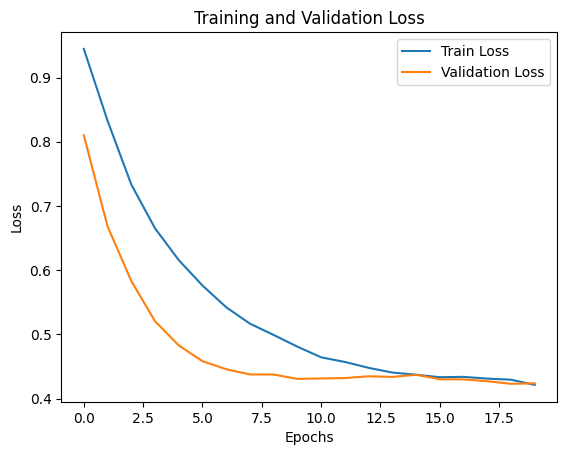

In [16]:
plt.plot(siamese_model.history.history['loss'], label="Train Loss")
plt.plot(siamese_model.history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

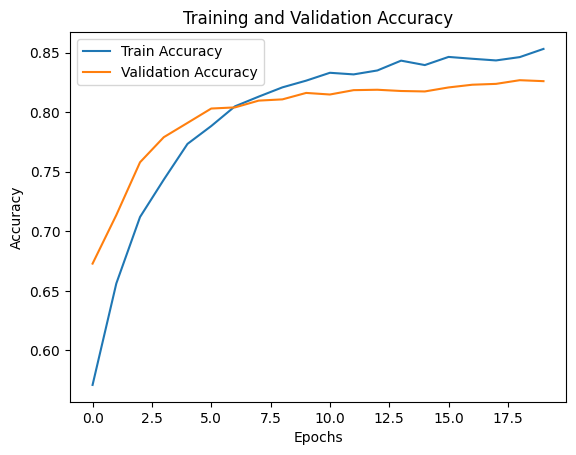

In [17]:
plt.plot(siamese_model.history.history['siamese_accuracy'], label="Train Accuracy")
plt.plot(siamese_model.history.history['val_siamese_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

In [18]:
test_loss, test_triplet_acc = siamese_model.evaluate(
    test_dataset,
    verbose=1
)
print(f"Test Triplet Loss: {test_loss:.4f}")
print(f"Test Triplet Accuracy: {test_triplet_acc:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 526ms/step - loss: 0.4932 - siamese_accuracy: 0.8027
Test Triplet Loss: 0.4661
Test Triplet Accuracy: 0.8111


In [25]:
import random

def generate_embeddings_with_labels(root_dir, embedding_model, preprocess_fn, num_images_per_person=5):
    embeddings = []
    labels = []
    label_to_name = {}
    
    for label_idx, person_name in enumerate(sorted(os.listdir(root_dir))):
        person_dir = os.path.join(root_dir, person_name)
        
        if not os.path.isdir(person_dir):
            continue
            
        label_to_name[label_idx] = person_name
        
        person_embeddings = []
        
        img_paths = [os.path.join(person_dir, img_name) for img_name in os.listdir(person_dir) if img_name.endswith(('jpg', 'png', 'jpeg'))]
        
        # Randomly select num_images_per_person images
        selected_images = random.sample(img_paths, min(num_images_per_person, len(img_paths)))  # Ensure not exceeding available images
        
        for img_path in selected_images:
            img = load_img(img_path, target_size=(224, 224))
            img = img_to_array(img)
            img = preprocess_fn(img)
            
            # Generate embedding
            embedding = embedding_model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
            
            person_embeddings.append(embedding)
        
        if person_embeddings:
            # Calculate average embedding
            avg_embedding = np.mean(person_embeddings, axis=0)
            embeddings.append(avg_embedding)
            labels.append(label_idx)
            
    return np.array(embeddings), np.array(labels), label_to_name


# Example usage:
registered_embeddings, registered_labels, label_map = generate_embeddings_with_labels(
        root_dir=config.TEST_DIR,
    embedding_model=inference_embedding,
    preprocess_fn=preprocess_input,
    num_images_per_person=5  # Limit to 5 images per person
)

print(f"Generated average embeddings for {len(registered_embeddings)} people")
print(f"Embedding shape: {registered_embeddings.shape}")
print(f"Label shape: {registered_labels.shape}")
print("Label mapping:", label_map)


Generated average embeddings for 18 people
Embedding shape: (18, 128)
Label shape: (18,)
Label mapping: {0: 'pins_Adriana Lima', 1: 'pins_Alexandra Daddario', 2: 'pins_Anne Hathaway', 3: 'pins_Brenton Thwaites', 4: 'pins_Emilia Clarke', 5: 'pins_Emma Watson', 6: 'pins_Katherine Langford', 7: 'pins_Leonardo DiCaprio', 8: 'pins_Logan Lerman', 9: 'pins_Megan Fox', 10: 'pins_Robert Downey Jr', 11: 'pins_Sophie Turner', 12: 'pins_alycia dabnem carey', 13: 'pins_amber heard', 14: 'pins_elizabeth olsen', 15: 'pins_kiernen shipka', 16: 'pins_margot robbie', 17: 'pins_scarlett johansson'}


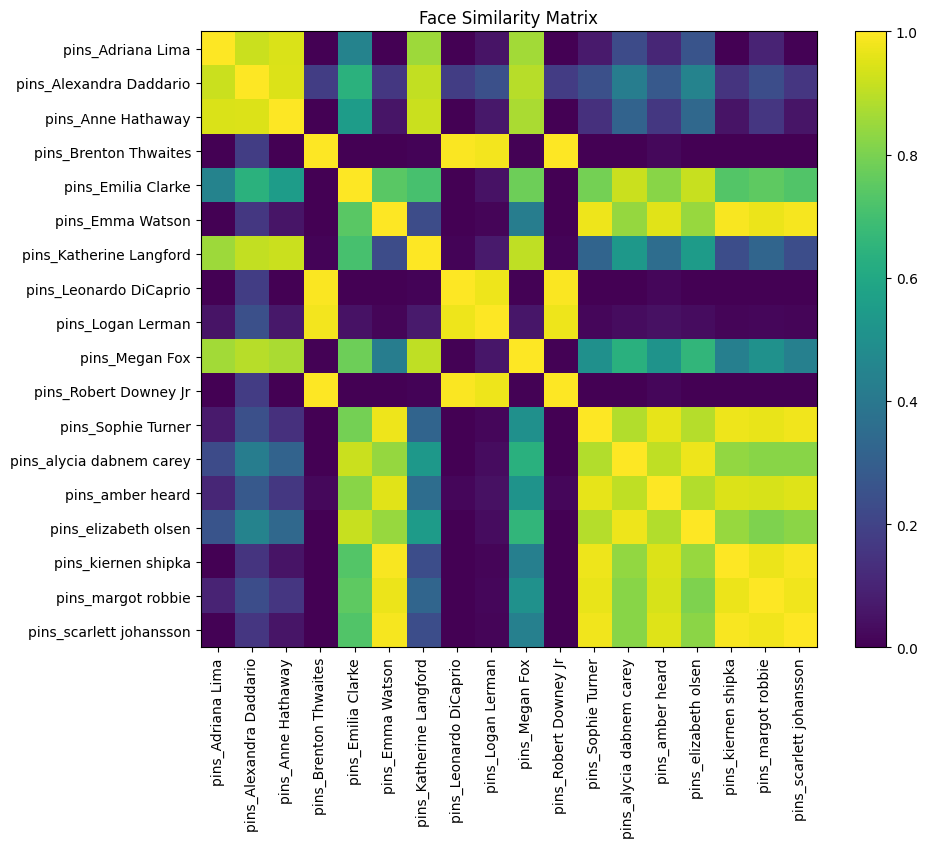

In [26]:
from sklearn.metrics import pairwise_distances
def plot_similarity_matrix(embeddings, labels, n_samples=18):
    # Get subset of embeddings
    _, indices = np.unique(labels, return_index=True)
    sample_indices = indices[:n_samples]
    
    # Calculate similarity
    sample_embeddings = embeddings[sample_indices]
    similarity = 1 - pairwise_distances(sample_embeddings, metric='cosine')
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.imshow(similarity, vmin=0, vmax=1)
    plt.colorbar()
    plt.xticks(range(n_samples), [label_map[l] for l in labels[sample_indices]], rotation=90)
    plt.yticks(range(n_samples), [label_map[l] for l in labels[sample_indices]])
    plt.title("Face Similarity Matrix")
    plt.show()

plot_similarity_matrix(registered_embeddings, registered_labels)